In [1]:
# import packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
from sklearn.svm import SVC

RSEED = 50

In [2]:
def load_kickstarter_data(datapath):
    '''datapath = location of csv files to be loaded'''
    # List with the names of all the csv files in the path
    csv_files = glob.glob(datapath+'/*.csv')

    print(f'Total files: {len(csv_files)}')

    # Loop through the files
    for file_idx, csv_file in enumerate(csv_files): 
        # create dataframe from 1st csv       
        if file_idx == 0:
            df_ks = pd.read_csv(csv_file)
            print(f'File number {file_idx + 1} added to dataframe')
        else:
            # create dataframe from idx csv
            df = pd.read_csv(csv_file)
            # check files are all in same
            if  np.all(df.columns == df_ks.columns) == False:
                print(f'Column format of {csv_file} does not match {csv_files[0]}. Please check and try again')
                return
            else:
                # append to initial dataframe                   
                df_ks = pd.concat([df_ks, df], axis=0, ignore_index=True)       
                print(f'File number {file_idx + 1} added to dataframe')
    print('File import done')
    return df_ks

In [3]:
def load_kickstarter_data_short(datapath):
    ''' 
    This is a version of the main function to load jsut 2 files for use in testing
    datapath = location of csv files to be loaded
    '''
    # List with the names of all the csv files in the path
    csv_files = glob.glob(datapath+'/*.csv')

    print(f'Total files: {len(csv_files)}')

    # Loop through the files
    for file_idx, csv_file in enumerate(csv_files): 
        # create dataframe from 1st csv       
        if file_idx == 0:
            df_ks = pd.read_csv(csv_file)
            print(f'File number {file_idx + 1} added to dataframe')
        else:
            # create dataframe from idx csv
            df = pd.read_csv(csv_file)
            # check files are all in same
            if  np.all(df.columns == df_ks.columns) == False:
                print(f'Column format of {csv_file} does not match {csv_files[0]}. Please check and try again')
                return
            else:
                # append to initial dataframe                   
                df_ks = pd.concat([df_ks, df], axis=0, ignore_index=True)       
                print(f'File number {file_idx + 1} added to dataframe')
                # This is here to prevent more than 2 files being loaded to save time in testing
                break
    print('File import done')
    return df_ks

In [4]:
def extract_json_data(data):
    ''' This function extracts specific sub fields from json files embedded in columns of a dataframe
        data: dataframe containing column with json data'''
    data['category_name'] = pd.DataFrame.from_dict([json.loads(data["category"][i])['name'] for i in range(data.shape[0])])
    data['category_slug'] = pd.DataFrame([json.loads(data["category"][i])['slug'] for i in range(data.shape[0])])
    # Split slug into main category and sub category
    data[['category_main','category_sub']] = df.category_slug.str.split(pat='/', n=1, expand=True)
    data.drop(labels = ['category','category_slug'], axis=1, inplace=True)
    
    print('json columns extracted')
    return data

In [5]:
def get_duration(data):
    #Convert from unix time stamp to more readable time format
    data['converted_deadline'] = pd.to_datetime(data['deadline'], unit='s')
    data['converted_launched_at'] = pd.to_datetime(data['launched_at'], unit='s')
    #Create project duration variable
    data['project_duration_days'] = (data['converted_deadline'] - data['converted_launched_at']).dt.days
    # Drop redundant columns
    data.drop(columns=['deadline', 'launched_at'], inplace=True)
    return data

In [6]:
def get_target(data,target='state', new_target_var='success', success_label='successful'):
    '''
    creates a dummy variable out of the state to be used as dependant variable
    '''
    #data('success') = data['state'].apply(lambda x: 1 if x == 'successful' else 0)
    data[new_target_var] = data[target].apply(lambda x: 1 if x == success_label else 0)
    return data

In [7]:
def clean_data(data):
    ''' Clean out the outliers and open campaigns data'''
    # print(df.goal.quantile(.98))
    goal_98_quantile = 200000
    data = data[data.state != 'live'] # change this to sucessful and others if you want cancelled etc. 
    data = data[data.goal < goal_98_quantile]
    return data

In [8]:
def get_target_and_features(data, target_var='success'):
    '''
    Function that splits dataset into target and feature dataframes
    '''
    #target = data['success']
    target = data[target_var]
    data.drop([target_var,'state'], axis = 1, inplace=True)
    features = data

    print('target and features split is done')
    return target, features

In [9]:
def currency_conversion(data):
    ''' Convert the currency of all projects to USD. '''
    # We use static_usd_rate since this is what was used for usd_pledged:
        # df['implied_fx_rate'] = df['usd_pledged'] / df['pledged'] ==  df['static_usd_rate']
    data['usd_goal'] = data['goal'] * data['static_usd_rate']
    # drop goal and static_usd_rate to remove redundant data
    data.drop(columns=['goal','static_usd_rate'], inplace=True)
    return data


In [10]:
def make_dummies(data, columns=['country', 'category_main','category_sub']):
    '''It does what it says :)'''
    data = pd.get_dummies(data, columns=columns, drop_first=True) #Avoid dummy trap   
    return data

In [11]:
def get_blurb_length(data):
    '''
    Create new features: Blurb length
    '''
    data['blurb_length'] = data.blurb.apply(lambda x: len(str(x)))
    return data

In [12]:
def fix_skew(data, skewed=['usd_goal']):
    '''Log-transform the skewed features'''
    data[skewed] = data[skewed].apply(lambda x: np.log(x + 1))
    return data

In [13]:
def scale_features(data, num_columns=['usd_goal','project_duration_days','blurb_length']):
    ''' Initialize a scaler, then apply it to the features'''    
    scaler = MinMaxScaler()
    data[num_columns] = scaler.fit_transform(data[num_columns])    
    return data

In [14]:
def drop_columns(data):
    '''remove unnecessary columns'''
    # Drop due to many missing values
    data.drop(columns = ['friends', 'is_backing', 'is_starred', 'permissions'], inplace=True)
    # Some Json strings varariables with unusable or already used data
    data.drop(columns = ['creator', 'location', 'photo', 'profile', 'slug', 'urls'], inplace=True)
    # Columns that are not specific to the campaign or are redundant or are technical data unrelated to campaign
    data.drop(columns = ['created_at','currency', 'currency_symbol', 'currency_trailing_code', 
                     'current_currency', 'disable_communication',
                     'is_starrable', 'source_url', 'spotlight', 'staff_pick', 
                     'usd_type', 'state_changed_at','fx_rate'], inplace=True)
    # drop columns due to being linked to dependent variable which would not be known in advance
    data.drop(columns = ['backers_count', 'converted_pledged_amount', 'pledged', 'usd_pledged','id'], inplace=True) # to be checked 'backers_count'
    # drop columns that are not used                
    data.drop(columns = ['blurb', 'name', 'converted_deadline', 'converted_launched_at','category_name',], inplace=True) 
    return data

In [15]:
from sklearn.utils import resample

def rebalance(X_train, y_train):
    
    # concatenate our training data back together
    X = pd.concat([X_train, y_train], axis=1)
    print(f'initial split \n{X.success.value_counts()}')
    # separate minority and majority classes
    fail = X[X.success==0]
    succeed = X[X.success==1]
  
    # upsample minority
    fail_upsampled = resample(fail,
                              replace=True, # sample with replacement
                              n_samples=len(succeed), # match number in majority class
                              random_state=RSEED) # reproducible results

    # combine majority and upsampled minority
    upsampled = pd.concat([succeed, fail_upsampled])

    # check new class counts
    print(f'final split \n{upsampled.success.value_counts()}')
    y_train = upsampled.success
    X_train = upsampled.drop('success', axis=1)
    return X_train, y_train

In [16]:
print(f'Starting balance: \n Heöö')

Starting balance: 
 Heöö


In [17]:
def test_train_split_kickstarter(features, target, test_size = 0.2, random_state = RSEED):
    '''
    Split data into train and test sets based on features and target dataframes.
    Shows results of the split and returns four dataframes
    '''
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = test_size, random_state = random_state)
    # Show the results of the split
    print ("Training set has {} samples.".format(X_train.shape[0]))
    print ("Testing set has {} samples.".format(X_test.shape[0]))
    return X_train, X_test, y_train, y_test

In [18]:
def train_using_gini(X_train, y_train):  
    # Creating the decision tree classifier object 
    clf_tree = DecisionTreeClassifier(criterion = "gini", 
            max_depth=3, min_samples_leaf=5) 
    # Performing training 
    clf_tree.fit(X_train, y_train) 
    return clf_tree

In [19]:
# Function to make predictions 
def prediction(X_test, clf_object): 
  
    # Predicton on test data with model trained using either giniIndex
    y_pred = clf_object.predict(X_test) 
    print("Predicted values:\n") 
    print(y_pred) 
    return y_pred 

In [20]:
def cal_accuracy(y_test, y_pred): 
      
    print("Confusion Matrix: \n", 
    confusion_matrix(y_test, y_pred)) 
      
    print ("Accuracy : \n", 
    accuracy_score(y_test, y_pred)*100) 
      
    print("Report : \n", 
    classification_report(y_test, y_pred)) 

In [21]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)
 #   train_fpr, model_tpr, _ = roc_curve(train_labels, train_probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
 #   plt.plot(train_fpr, model_tpr, 'g', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


In [22]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns, rotation=45 )
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

In [23]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [24]:
""" MAIN SCRIPT ============================================================="""
if __name__ == '__main__':
    # this script loads data and performs all manipulations in order to get it ready for use in a model
    # Read data

    df = load_kickstarter_data('kickstarter/data')
    
    # Extract category data from json
    df = extract_json_data(df)
    
    # data cleaning: drop campaigns that are still ongoing and outliers 
    
    df = clean_data(df)
    
    # convert unix timestamps and calculate campaign duration
    df = get_duration(df)
    
    # Get blurb length
    df = get_blurb_length(df)
    
    #create goal data in single currency
    df = currency_conversion(df)
    
    # encode target variable 'state' to numerical values, success is 1 all others are fail and 0
    df = get_target(df,target='state', new_target_var='success', success_label='successful')

    # drop unnecessary columns
    df=drop_columns(df)
    df.head()
       
    # Split the data into features and target label
    target, features = get_target_and_features(df)
    
    # split categorical columns into dummies
    cat_columns=['country', 'category_main','category_sub']
    features = make_dummies(features, cat_columns)
    
    # address skew   by applying logarithm  
    num_columns = ['project_duration_days', 'blurb_length', 'usd_goal']
    features = fix_skew(features, skewed=num_columns)
 
    # scale numerical features
    features = scale_features(features, num_columns)
    
    # Split into training and test set
    X_train, X_test, y_train, y_test = test_train_split_kickstarter(features, target, test_size = 0.2, random_state = RSEED)
    #display(y_train.head())
    
    # resample
    X_train, y_train = rebalance(X_train, y_train)

Total files: 56
File number 1 added to dataframe
File number 2 added to dataframe
File number 3 added to dataframe
File number 4 added to dataframe
File number 5 added to dataframe
File number 6 added to dataframe
File number 7 added to dataframe
File number 8 added to dataframe
File number 9 added to dataframe
File number 10 added to dataframe
File number 11 added to dataframe
File number 12 added to dataframe
File number 13 added to dataframe
File number 14 added to dataframe
File number 15 added to dataframe
File number 16 added to dataframe
File number 17 added to dataframe
File number 18 added to dataframe
File number 19 added to dataframe
File number 20 added to dataframe
File number 21 added to dataframe
File number 22 added to dataframe
File number 23 added to dataframe
File number 24 added to dataframe
File number 25 added to dataframe
File number 26 added to dataframe
File number 27 added to dataframe
File number 28 added to dataframe
File number 29 added to dataframe
File nu

In [25]:
# Check shape of dataframes
print('X_train.shape:',X_train.shape)
print('X_test.shape:',X_test.shape)
print('y_train.shape:',y_train.shape)
print('y_test.shape:',y_test.shape)
#print('y_pred.shape:',y_pred.shape)

X_train.shape: (186902, 181)
X_test.shape: (39550, 181)
y_train.shape: (186902,)
y_test.shape: (39550,)


In [26]:
def simple_decision_tree(X_train, X_test, y_train, y_test):
    '''This is the first model to set a baseline prediction'''
    # Fit a simple decision tree first
    clf_gini = train_using_gini(X_train, y_train) 
    
    # Create predictions using simple model - decision tree
    y_pred = prediction(X_test, clf_object=clf_gini)
    
    # show results
    cal_accuracy(y_test, y_pred)

In [27]:
# run simple decision tree model
simple_decision_tree(X_train, X_test, y_train, y_test)

Predicted values:

[1 1 1 ... 1 0 1]
Confusion Matrix: 
 [[ 5786 10429]
 [ 3553 19782]]
Accuracy : 
 64.6472819216182
Report : 
               precision    recall  f1-score   support

           0       0.62      0.36      0.45     16215
           1       0.65      0.85      0.74     23335

    accuracy                           0.65     39550
   macro avg       0.64      0.60      0.60     39550
weighted avg       0.64      0.65      0.62     39550



In [28]:
# Import the SVC model from sklearn
from sklearn.svm import SVC

def SVM_model_tiral(X_train, y_train, X_test, y_test):
    ''' This function tries a Support Vector Classifier to see if we can handle the data volume'''
    # we will try it out on 3 small subsets and compare to simple decision tree.
    svm_trial = SVC(random_state = RSEED)

    # TODO: Calculate the number of samples for 1%, 5%, and 10% of the training data
    samples_1 = int(round(len(X_train) / 100))
    samples_5 = int(round(len(X_train) / 20))
    samples_10 = int(round(len(X_train) / 10))

    # Collect results on the learners
    results = {}
    for clf in [svm_trial]:
        clf_name = svm_trial.__class__.__name__
        results[clf_name] = {}
        for i, samples in enumerate([samples_1, samples_5, samples_10]):
            results[clf_name][i] = \
            train_predict(clf, samples, X_train, y_train, X_test, y_test)
    for i in results.items():
        print (i[0])
        display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'5%', 2:'10%'}))
# Results show that it is already very slow on 1% and 5% of data
# and the results are not promising so we will try other models

In [29]:
# hashed out because it takes so long
#SVM_model_tiral(X_train, y_train, X_test, y_test)


In [32]:
# Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import seaborn as sns

def complex_model_selection(X_train, y_train, X_test, y_test):
    '''This function runs three models to determine which model is the best candidate for further review'''
    # Initialize the three models, the random states are set to RSEED so we know how to reproduce the model later
    clf_A = DecisionTreeClassifier(random_state=RSEED)
    clf_B = RandomForestClassifier(n_estimators=120, min_samples_split=4, random_state = RSEED, n_jobs=-1)
    clf_C = AdaBoostClassifier(random_state = RSEED)

    # Calculate the number of samples for 1%, 10%, and 100% of the training data
    samples_1 = int(round(len(X_train) / 100))
    samples_10 = int(round(len(X_train) / 10))
    samples_100 = int(round(len(X_train) / 1))

    # Collect results on the learners
    results = {}
    for clf in [clf_A, clf_B, clf_C]:
        clf_name = clf.__class__.__name__
        results[clf_name] = {}
        for i, samples in enumerate([samples_1, samples_10, samples_100]):
            results[clf_name][i] = \
            train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
    # Printing out the values
    for i in results.items():
        print (i[0])
        display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))
    from sklearn.metrics import confusion_matrix

    for i,model in enumerate([clf_A,clf_B,clf_C]):
        cm = confusion_matrix(y_test, model.predict(X_test))
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

        # view with a heatmap
        plt.figure(i)
        sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
                cmap='Blues', square=True, fmt='.3f')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));
    # Random forest has the best scores and does not take significantly longer to train than adaboost 

DecisionTreeClassifier trained on 1869 samples.
DecisionTreeClassifier trained on 18690 samples.
DecisionTreeClassifier trained on 186902 samples.
RandomForestClassifier trained on 1869 samples.
RandomForestClassifier trained on 18690 samples.
RandomForestClassifier trained on 186902 samples.
AdaBoostClassifier trained on 1869 samples.
AdaBoostClassifier trained on 18690 samples.
AdaBoostClassifier trained on 186902 samples.
DecisionTreeClassifier


,1%,10%,100%
train_time,0.008617,0.033584,12.015818
pred_time,0.101073,0.071534,0.083058
acc_train,1.000000,1.000000,0.986667
acc_test,0.590013,0.590013,0.741239
f_train,1.000000,1.000000,0.997305
f_test,0.642714,0.642714,0.769252


RandomForestClassifier


,1%,10%,100%
train_time,0.238894,0.254309,32.712300
pred_time,0.128618,0.115252,0.650808
acc_train,1.000000,1.000000,0.976667
acc_test,0.590013,0.590013,0.781264
f_train,1.000000,1.000000,0.995245
f_test,0.642714,0.642714,0.806027


AdaBoostClassifier


,1%,10%,100%
train_time,0.008457,0.033160,25.724585
pred_time,0.053691,0.057261,0.816181
acc_train,1.000000,1.000000,0.646667
acc_test,0.590013,0.590013,0.726802
f_train,1.000000,1.000000,0.901487
f_test,0.642714,0.642714,0.798660


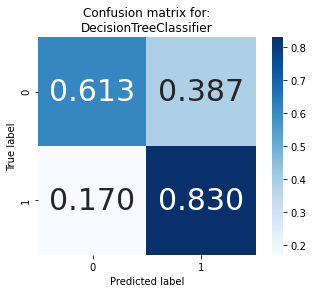

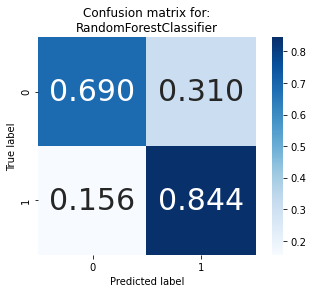

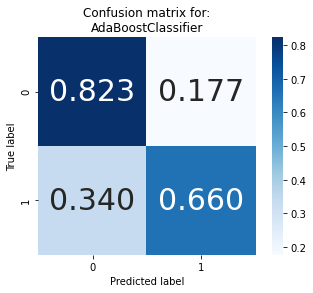

In [33]:
# run complex model selection
complex_model_selection(X_train, y_train, X_test, y_test)

In [32]:
X_train.columns

Index(['project_duration_days', 'blurb_length', 'usd_goal', 'country_AU',
       'country_BE', 'country_CA', 'country_CH', 'country_DE', 'country_DK',
       'country_ES', 'country_FR', 'country_GB', 'country_HK', 'country_IE',
       'country_IT', 'country_JP', 'country_LU', 'country_MX', 'country_NL',
       'country_NO', 'country_NZ', 'country_SE', 'country_SG', 'country_US',
       'category_main_comics', 'category_main_crafts', 'category_main_dance',
       'category_main_design', 'category_main_fashion',
       'category_main_film & video', 'category_main_food',
       'category_main_games', 'category_main_journalism',
       'category_main_music', 'category_main_photography',
       'category_main_publishing', 'category_main_technology',
       'category_main_theater'],
      dtype='object')

In [43]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import make_scorer 
from sklearn.ensemble import RandomForestClassifier

# TODO: Initialize the classifier
def RandomForest_complex_model
    clf = RandomForestClassifier()

    # TODO: Create the parameters list you wish to tune
    rs_params = {'n_estimators':[50, 100, 120],                
                  'max_depth': [None] + list(np.arange(2, 8, 2)),    
                  'min_samples_split' : np.arange(2, 16, 4),                           
                  'max_features': ['sqrt', None] + list(np.arange(0.2, .8, 0.2)),
                  'max_leaf_nodes': [None] + list(np.arange(30, 70, 10)),
                 } 
    gs_params = {'n_estimators':[80, 100, 120],                
                  'max_depth': [None] + list(np.arange(2, 8, 2)),    
                  'min_samples_split' : np.arange(4, 10, 2)                        
                 } 



    # TODO: Make an fbeta_score scoring object
    scorer = make_scorer(score_func=fbeta_score, beta=0.5) 

    # TODO: Perform grid search on the classifier using 'scorer' as the scoring method
    grid_obj = GridSearchCV(clf, gs_params, scorer, verbose=5, n_jobs=-1)
    #rs = RandomizedSearchCV(clf, rs_params, n_jobs = -1, 
    #                        scoring = 'roc_auc', cv = 5, 
    #                        n_iter = 20, verbose = 5, random_state=RSEED)
    # TODO: Fit the grid search object to the training data and find the optimal parameters
    grid_fit = grid_obj.fit(X_train,y_train) 
    #grid_fit = rs.fit(X_train,y_train) 

    # Get the estimator
    best_clf = grid_fit.best_estimator_ 

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test) 

    # Report the before-and-afterscores
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
    print("\nOptimized Model\n------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
    print(best_clf)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/andrewemmett/opt/anaconda3/envs/nf_2nd_project/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass scoring=make_scorer(fbeta_score, beta=0.5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 19.9min finished


Unoptimized model
------
Accuracy score on testing data: 0.7806
F-score on testing data: 0.8044

Optimized Model
------
Final accuracy score on the testing data: 0.7812
Final F-score on the testing data: 0.8058
RandomForestClassifier(min_samples_split=4, n_estimators=120)


In [ ]:
predictions = (clf.fit(X_train, y_train)).predict(X_test)
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))

In [33]:

# TODO: Import a supervised learning model that has 'feature_importances_'
model_grid = best_clf

# TODO: Extract the feature importances
importances_grid =  model_grid.feature_importances_

feature_plot(importances_grid, X_train, y_train)



NameError: name 'best_clf' is not defined

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import make_scorer 

# TODO: Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators':[50, 120],                
              'learning_rate':[0.1, 0.5, 1.],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 4, 1)              
             } 

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5) 

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scorer, verbose=1, n_jobs=-1)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train) 

# Get the estimator
best_clf = grid_fit.best_estimator_ 

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test) 

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Users/andrewemmett/opt/anaconda3/envs/nf_2nd_project/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass scoring=make_scorer(fbeta_score, beta=0.5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 31.3min
